# Build a language model based on wikipedia in you language 

The notebooke includes the whole process but you will need to help the process if the following problem happens:  
-you internet connection is interrupted (stage 1)

-you run out of diskspace

-because of the huge memory consumption. creatig the databunch for the training requires lots of memory


In order ot handle these problemn the notebook is divided into stages. If the process is failes in a stage then you can resume the processing from the beginning of that stage by:
-restarting the kernel "Kernel"/Restart & Clear Output

-running the cells in stage 0: initialization

-running the cells from the start of the stage that failed 

# Stage 0: Initialisation
lang: You must set the parameter "lang" to the language you want to build a model for. Fx:

fr: for french

en: for english

de:for german

da: for danish 

etc.

pathData: You must se the location where you want your data stored using the parameter pathData. Consider using a ssd-rive

In [1]:
lang="en"

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.text import * 
#from fastai.utils.ipython import *

from IPython.display import display, HTML
from pathlib import *
import re
import shutil

In [4]:
pathData       = Path("../../data/nlp")
path           = pathData / lang
pathDump       = path/"wiki-dump"
pathJson       = path/"wiki-json"

pathTrainValid = path/"wiki-train_valid"
pathTxt        = pathTrainValid/"txt"
pathToks       = pathTrainValid/"toks"
pathcsv        = pathTrainValid/"wiki.csv"

cache_name   = "sp-model"
pathVocab    = pathTrainValid / cache_name

# requried libraries: 
conda install -c anaconda psutil 

conda install -c anaconda git 

#conda install -c menpo wget 
conda install curl


# Stage 1: download the selected language from wikipedia and convert the articles to json

In [5]:
if len(list(pathDump.glob("*.bz2")))==0:
    pathDump.mkdir(parents=True,exist_ok=True)
    #fn  = f"{lang}wiki-latest-pages-articles.xml.bz2"
    fn  = f"{lang}wiki-latest-pages-articles-multistream.xml.bz2"
    url = f"https://dumps.wikimedia.org/{lang}wiki/latest/{fn}"
    #cmd = f"wget -c --no-check-certificate --show-progress {str(url)} -P {str(pathDump)}"
    cmd = f'curl -k -C - -o "{str(pathDump/fn)}" "{str(url)}"'
    print(f"If the command fails in the notebook then copy the command and run it in the terminal:{cmd}")
    ! $cmd

# Stage 2: Convert wikipedia dump to articles in json

In [6]:
pathWikiExtractor = Path("../wikiextractor")

In [7]:
if not pathJson.exists():
    !git clone https://github.com/attardi/wikiextractor.git $pathWikiExtractor
    cmd = f"cd {str(pathWikiExtractor)} && python setup.py install"
    ! $cmd

In [8]:
%%time
if not pathJson.exists():
    #extracting the json-files. This takes about 1 hour for french with files read from and saved to a ssd hardrive 
    fn_wikidump = list(pathDump.iterdir())[0]
    cmd = f"cd {str(pathWikiExtractor)} && python WikiExtractor.py -o {str(pathJson)} --json --processes {defaults.cpus} -q --filter_disambig_pages --no-templates --discard_elements gallery,timeline,noinclude {str(fn_wikidump)}"
    print(f"If WikiExtractor fails in the notebook then copy the command and run it in the terminal:{cmd}")
    ! $cmd

Wall time: 0 ns


# Stage 3: building a vocabulary using sentencepiece

Now we separate the title of the wikipedia section from text section that we keep. 

In order to makes a first reduction on the number of section we clean the text with the preprocessing rules from fastai and ignore text with less than "minWords"

You must set the lenght of the shortes sections to keep using the parameter "minWords"

In [9]:
minWords  = 1
chunksize = 25000

In [10]:
!pip install sentencepiece

In [11]:
from fastai_sentencepiece import *
from filetokenizer import *

In [12]:
data = None
if not pathTxt.exists():
    swm = SentencepieceWikiVocab(lang=lang, pathJson=pathJson, pathcsv=pathcsv, pathTxt=pathTxt, pathVocab=pathVocab)    
    %time swm.wikijson2TrainingData()
    %time data = pd.read_csv(pathcsv)
    gc.collect()

In [13]:
if data is not None:
    percentiles = 0.01 * np.asarray([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 
                                     1,2,3,4,10,20, 50, 75, 90, 95, 96, 97, 98, 
                                     99, 99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9,99.99]) 
    %time display(data.describe(percentiles,include=[np.number]))
    print(f"data:{data.shape}")

In [14]:
#analyse thresholds used to clean wikipedia
if data is not None:
    lpl = data.hyphens_pr_alpha.values
    ix = lpl>2
    data_empty = data[ix]
    print(f"data_empty:{data_empty.shape}")
    
    percentiles = 0.01 * np.asarray([1, 10, 25, 50, 75, 90, 99])     
    %time data_empty.describe(percentiles,include=[np.number])
    display(data_empty)
    print(data_empty.text.head().values)
    print(data_empty.text.tail().values)
    gc.collect()

In [15]:
if not (pathVocab/"m.model").exists():
    swm = SentencepieceWikiVocab(lang=lang, pathJson=pathJson, pathcsv=pathcsv, pathTxt=pathTxt, pathVocab=pathVocab)
    %time swm.trainVocabulary()

In [16]:
if not (pathVocab/"itos.pkl").exists():
    swm = SentencepieceWikiVocab(lang=lang, pathJson=pathJson, pathcsv=pathcsv, pathTxt=pathTxt, pathVocab=pathVocab)
    swm.convertSPVocab2FastaiVocab()

# Show some examples using the vocabulary

In [17]:
swm = SentencepieceWikiVocab(lang=lang, pathJson=pathJson, pathcsv=pathcsv, pathTxt=pathTxt, pathVocab=pathVocab)
sp  = spm.SentencePieceProcessor()
sp.Load(str(pathVocab / "m.model"))
print("\nSize of vocabulary:",sp.GetPieceSize())

control_symbols = ["<unk>","xxbos","xxeos","xxpad"]
print(f"Control symbol:")
for s in control_symbols: print(f"{s}({sp.PieceToId(s)})")

print(f"\nUser defined symbols:")
for s in swm.getUserdefinedSymbols():print(f"{s}({sp.PieceToId(s)})")

sentence = "She is tall. He is small".lower()
print(f"Sentence:          {sentence}")
print(f"Sentence as pieces:{sp.EncodeAsPieces(sentence)}")
print(f"Sentence as ids:   {sp.EncodeAsIds(sentence)}")
print(f"Sentence from ids:   {sp.DecodeIds(sp.EncodeAsIds(sentence))}")


Size of vocabulary: 4000
Control symbol:
<unk>(0)
xxbos(1)
xxeos(2)
xxpad(3)

User defined symbols:
xxfld(4)
xxmaj(5)
xxup(6)
xxrep(7)
xxwrep(8)
0(9)
1(10)
2(11)
3(12)
4(13)
5(14)
6(15)
7(16)
8(17)
9(18)
°(19)
%(20)
$(21)
§(22)
£(23)
€(24)
((25)
)(26)
<(27)
>(28)
"(29)
'(30)
“(31)
”(32)
‘(33)
’(34)
!(35)
,(57)
;(36)
:(37)
.(38)
•(39)
—(40)
|(41)
\(42)
/(43)
*(44)
+(45)
-(46)
=(47)
⁄(48)
′(49)
_(50)
#(51)
&(52)
?(53)
Sentence:          she is tall. he is small
Sentence as pieces:['▁she', '▁is', '▁tall', '.', '▁he', '▁is', '▁small']
Sentence as ids:   [124, 66, 3097, 38, 72, 66, 551]
Sentence from ids:   she is tall. he is small


# Prepare training of the language model

# LM Training
Set the minimum number of tokens for the sections that we shall retain

In [18]:
spt_func  = partial(SentencepieceTokenizer.create, pathVocab=pathVocab)
spt_func.__name__ = SentencepieceTokenizer.__name__
spt       = spt_func(lang="en")

unk_idx,pad_idx = spt.vocab().numericalize([text.transform.UNK])[0], spt.vocab().numericalize([text.transform.PAD])[0]
print(f"unk_idx:{unk_idx} pad_idx:{pad_idx}")
vocab,max_vocab = spt.vocab(), len(spt.vocab().itos)
trainTokenizer  = SPFileTokenizer(pathToks/"train", spt_func,"en",vocab,n_cpus=max(defaults.cpus-1,1))
validTokenizer  = SPFileTokenizer(pathToks/"valid", spt_func,"en",vocab,n_cpus=max(defaults.cpus-1,1))

unk_idx:0 pad_idx:3


In [19]:
split_ratio = 0.2
if not (pathToks/"train").exists() or not (pathToks/"valid").exists():
    files = list(pathTxt.glob("*.txt"))
    random.seed(1)
    random.shuffle(files)
    random.seed()
    splitindex = int(len(files)*split_ratio+.5)
    trainList  = TextList( files[:-splitindex], vocab=vocab, pad_idx=pad_idx, 
                           processor=[SPFileTokenizeProcessor(tokenizer=trainTokenizer, chunksize=0)])
    validList  = TextList( files[-splitindex:], vocab=vocab, pad_idx=pad_idx, 
                           processor=[SPFileTokenizeProcessor(tokenizer=validTokenizer, chunksize=0)])

In [20]:
if not (pathToks/"train").exists():
    %time trainList.process()
    trainList=None
    gc.collect()    

In [21]:
if not (pathToks/"valid").exists():
    %time p = validList.process()
    validList=None
    gc.collect()

# The following cells are used to find macUnk, minToks and maxToks.
The 4 cells were deactivate after deciding on these values

In [22]:
check_statistics=False
if check_statistics:
    %time trainIDS = trainTokenizer.getIds()
    %time validIDS = validTokenizer.getIds()
else:
    trainIDS = validIDS = None

In [23]:
#how much do we loos by removing sentences with unks
if trainIDS is not None:
    unkPrSentence        = np.asarray([np.sum(s==unk_idx) for s in trainIDS],dtype=np.int)
    percentUnkPrSentence = np.asarray([np.sum(s==unk_idx)/len(s) for s in trainIDS])
    percent              = np.asarray([0, 50, 75, 90, 97, 98.5, 99, 99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9, 99.95,  99.99, 100]) 
    percentiles          = np.percentile(unkPrSentence,percent).astype(np.int)
    print("unkPrSentence %  percentile ")
    for i in range(len(percent)):print(f"{percent[i]}  {percentiles[i]}")   

    unkPrSentence=None
    gc.collect()

In [24]:
if trainIDS is not None:
    print(f"Traning:    number of arrays:{len(trainIDS)} - number of ids:{sum(len(ids) for ids in trainIDS)}")
    print(f"Validation: number of arrays:{len(validIDS)} - number of ids:{sum(len(ids) for ids in validIDS)}")

    #Analyse the distribution of the legnth of tokens sequences in the ragged/jagged array of tokes
    sectionlengths = np.asarray([len(s) for s in trainIDS],dtype=np.int32)
    plt.hist(sectionlengths[sectionlengths<600], 250, density=True, facecolor='g', alpha=0.75)
    np.histogram(sectionlengths[sectionlengths<1000],50)

    print(f"Lenght of token rags min:{min(sectionlengths)} max:{np.max(sectionlengths)} - median:{np.median(sectionlengths)}")
    print(f"Lenght of token rags mean:{np.mean(sectionlengths)} std:{np.std(sectionlengths)}")

    percent     = np.asarray([ 0, 0.11, 0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9, 1, 1.5, 2, 25,50,75,90,97,99,99.5,99.9,99.99,100]) # %np.arange(101,dtype=np.int)
    percentiles = np.percentile(sectionlengths,percent).astype(np.int)
    print("%  percentile")
    for i in range(len(percent)):print(f"{percent[i]}  {percentiles[i]}")
    minToks = percentiles[np.where( percent==0.11 )[0][0]]
    maxToks = percentiles[np.where( percent==99.99 )[0][0]]
    print(f"\nminToks:{minToks} maxToks:{maxToks}")
    print(f"rags <= minToks:{np.sum(sectionlengths <= minToks)}")
    print(f"rags >= maxToks:{np.sum(sectionlengths >= maxToks)}")

    sectionlengths = trainIDS = validIDS = None
    gc.collect()

In [25]:
maxUnks,minToks,maxToks,train_count,valid_count = 0,15,600,-1,-1
%time trainIDS = trainTokenizer.getIds(minToks, maxToks, maxUnks, unk_idx=unk_idx, count=train_count)
%time validIDS = validTokenizer.getIds(minToks, maxToks, maxUnks, unk_idx=unk_idx, count=valid_count)
np.random.seed(1)
np.random.shuffle(trainIDS)
np.random.shuffle(validIDS)
np.random.seed()

Wall time: 2min 25s
Wall time: 39.2 s


Training:   number of arrays:22441843 - number of ids:2595089714
Lenght of training sentences:   min:15 max:600 - median:94.0


7

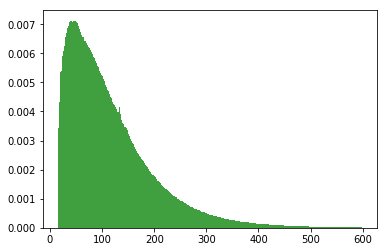

In [26]:
train_lengths = np.fromiter( (len(s) for s in trainIDS), dtype=np.int16, count=len(trainIDS) )
print(f"Training:   number of arrays:{len(trainIDS)} - number of ids:{sum(len(ids) for ids in trainIDS)}")
print(f"Lenght of training sentences:   min:{np.min(train_lengths)} max:{np.max(train_lengths)} - median:{np.median(train_lengths)}")
plt.hist(train_lengths[train_lengths<maxToks], np.max(train_lengths)-np.min(train_lengths), density=True, facecolor='g', alpha=0.75, label="sentencelength for training data" )
gc.collect()

Validation: number of arrays:6071744 - number of ids:671486551
Lenght of validation sentences: min:15 max:600 - median:89.0


33512

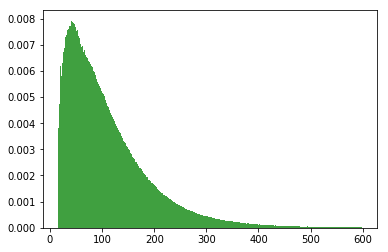

In [27]:
valid_lengths = np.fromiter( (len(s) for s in validIDS), dtype=np.int16, count=len(validIDS) )
print(f"Validation: number of arrays:{len(validIDS)} - number of ids:{sum(len(ids) for ids in validIDS)}")
print(f"Lenght of validation sentences: min:{np.min(valid_lengths)} max:{np.max(valid_lengths)} - median:{np.median(valid_lengths)}")
plt.hist(valid_lengths[valid_lengths<maxToks], np.max(train_lengths)-np.min(train_lengths), density=True, facecolor='g', alpha=0.75, label="sentencelength for validation data" )
gc.collect()

In [28]:
def getNSentencens(sentencelengths, nTokens:int): 
    i,ln_lenghts=0,len(sentencelengths)
    while nTokens>0 and i<ln_lenghts: 
        nTokens -= sentencelengths[i]
        i       += 1
    return i

In [60]:
#from languagemodelloader import *

nTrainToks = int(2.5e8)

nValidToks = int(0.2*nTrainToks+1)
nTrainSentences, nValidSentences = getNSentencens(train_lengths,nTrainToks), getNSentencens(valid_lengths,nValidToks)
selectedTrainToks = np.sum(train_lengths[:nTrainSentences],dtype=np.int64)
selectedValidToks = np.sum(valid_lengths[:nValidSentences],dtype=np.int64)
trainIDS_         = trainIDS[:nTrainSentences]
validIDS_         = validIDS[:nValidSentences]
print(f"specified training tokens    :{nTrainToks}\nselected training tokens     :{selectedTrainToks}\nselected training sentences  :{nTrainSentences}" )
print(f"\n\nspecified validation tokens  :{nValidToks}\nselected validation tokens   :{selectedValidToks}\nselected validation sentences:{nValidSentences}" )
#trainIDS = validIDS = None
gc.collect()

specified training tokens    :250000000
selected training tokens     :250000000
selected training sentences  :2158673


specified validation tokens  :50000001
selected validation tokens   :50000021
selected validation sentences:452165


69

In [61]:
class Model(IntEnum):
    awd_lstm      = 1
    transformer   = 2
    transformerXL = 3

def get_language_model_learner(model,data):
    if model is Model.awd_lstm :
        default_dropout = {'language':   np.array([0.25, 0.1, 0.2, 0.02, 0.15]),
                           'classifier': np.array([0.4,0.5,0.05,0.3,0.4])}
        dps = default_dropout["language"]
        input_p, output_p, weight_p, embed_p, hidden_p, out_bias = dps[0], dps[1],dps[2],dps[3],dps[4], True  
        
        cfg = awd_lstm_lm_config.copy()
        cfg['qrnn'],cfg['emb_sz'],cfg['n_hid'],cfg['n_layers'],cfg['tie_weights'], cfg['pad_token'] =\
             False,      256,          1280,            3,           True,               pad_idx 
        cfg['input_p'],cfg['weight_p'],cfg['embed_p'],cfg['hidden_p'],cfg['output_p'], cfg['out_bias']=\
             input_p,       weight_p,       embed_p,       hidden_p,       output_p,   out_bias
        
        train_epochs =    { int(2.5e9):1, 
                            int(2.5e8):10,
                            int(2.5e7):100
                          }
        model_drop_mult = { int(2.5e9):0, 
                            int(2.5e8):0.1
                          }
        drop_mult = model_drop_mult[nTrainToks]   
        wd        = 1e-3
        pct_start = 0.2
        moms      = (0.70, 0.80)
        max_lr    = 2e-3
        learn = language_model_learner(data, AWD_LSTM,config=cfg, drop_mult=drop_mult, pretrained=False, callback_fns=ShowGraph )
        print(cfg)       
    elif model is Model.transformer:    
        learn = language_model_learner(data, Transformer,config=None, drop_mult=drop_mult, pretrained=False, callback_fns=ShowGraph )
        print(cfg)
    else : 
        train_epoch =    {  int(2.5e9):1, 
                            int(2.5e8):3,
                            int(2.5e7):20
                          }
        model_drop_mult = {int(2.5e9):0. 
                           int(2.5e8):0.05,
                           int(2.5e7):0.15,
                           int(2.5e6):1.7,
        drop_mult = model_drop_mult[nTrainToks]   
        wd        = 1e-5
        pct_start = 0.02
        moms      = (0.74, 0.84)
        max_lr    = 5e-4
        learn = language_model_learner(data, TransformerXL,config=None, drop_mult=drop_mult, pretrained=False, callback_fns=ShowGraph)
    epoch     = train_epochs[nTrainToks]                             }
    return learn, epochs, drop_mult, wd, pct_start, moms, max_lr 



In [62]:
dblm = TextLMDataBunch.from_ids( pathTrainValid, vocab, trainIDS_, validIDS_, bs=64, bptt=70, num_workers=0, no_check=True)
dblm.show_batch()

model = Model.awd_lstm
learn, epochs, drop_mult, wd, pct_start, moms, max_lr = get_language_model_learner(model, data=dblm)

idx,text
0,in 1927 the line was further expanded to six tracks (four with electrification) and newtown station was demolished and replaced by the present station which served only the up and down local tracks. the new station was opened on 29 may 1927. the
1,ricketts. ricketts broke his right hand after colliding with gonzalez's foot and elected to continue playing after being evaluated by on-field trainers. salt lake continued attacking and findley scored the equalizing goal in the 64th minute by finish
2,"ic property of england, wished above all to inculcate on his countrymen the teachings of healthy practical activity to be found in the works of the english dramatist. the object for which he wrote, that is the moral improvement of his readers from a practical point of view"
3,"s and albert schweitzer for their performances of bach's organ music. concept work began during the middle of production on the ""persona 2"" duology. featuring staff from the ""megami tensei"" franchise including artist kazuma kaneko and composer"
4,"scatterbrained, malaprop-prone jane (""you've got to take the bitter with the better"", ""time wounds all heels""), ""easy aces"" became a long-running serial comedy"


{'emb_sz': 256, 'n_hid': 1280, 'n_layers': 3, 'pad_token': 3, 'qrnn': False, 'bidir': False, 'hidden_p': 0.015, 'input_p': 0.025, 'embed_p': 0.002, 'weight_p': 0.020000000000000004}


In [63]:
__version__

'1.0.50.dev0'

In [ ]:
%time learn.lr_find(wd=1e-3)
learn.recorder.plot(skip_start=0, skip_end=12)

awd_lstm


epoch,train_loss,valid_loss,accuracy,time
0,3.362826,3.316758,0.373913,1:43:24
1,3.221535,3.183693,0.387789,1:43:54
2,3.170147,3.102595,0.398512,1:42:22
3,3.103542,3.049831,0.405684,1:42:19
4,3.046348,3.002597,0.412458,1:43:37
5,3.009161,2.958081,0.418963,1:44:24
6,2.954202,2.918493,0.424909,1:44:30
7,2.914738,2.888287,0.429561,1:43:25
8,2.878951,2.871585,0.432237,1:43:01
9,2.869374,2.868371,0.432830,1:42:15


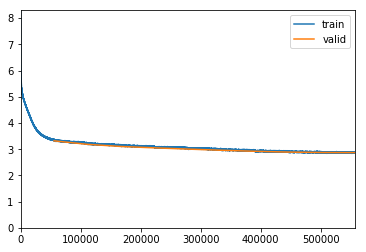

Wall time: 17h 13min 58s


In [70]:
print(f"fastai version:{__version__}")
print(f"mode:{model.name}")
print(f"epochs:{epochs} drop_mult:{drop_mult} wd:{wd} pct_start:{pct_start} moms:{moms} max_lr:{max_lr}"")
%time learn.fit_one_cycle(cyc_len=epochs, max_lr=max_lr, moms=moms, wd=wd, pct_start=pct_start)  

#if model is Model.awd_lstm :
#    %time learn.fit_one_cycle(cyc_len=epochs, max_lr=2e-3, moms=(0.70, 0.80), wd=1e-3, pct_start=0.2)  
#    #%time learn.fit_one_cycle(cyc_len=epochs, max_lr=2e-3, moms=(0.70, 0.80), wd=1e-5, pct_start=0.02)  
#elif model is Model.transformer:    
#    %time learn.fit_one_cycle(cyc_len=epochs, max_lr=5e-4, moms=(0.74, 0.84), wd=1e-5, pct_start=0.02)
#else:    
#    %time learn.fit_one_cycle(cyc_len=epochs, max_lr=5e-4, moms=(0.74, 0.84), wd=1e-5, pct_start=0.02)


In [71]:
#remember to update the last validation loss to get your perplexity score
print( f"Perplexity: {exp(2.868371)}") #best: 2.809459
trainTokens={sum(len(s) for s in trainIDS_)}
print( f"Number of tokens in trainingdata:   {sum(len(s) for s in trainIDS_)}")
print( f"Number of tokens in validationdata: {sum(len(s) for s in validIDS_)}")
gc.collect()

Perplexity: 17.608310885645434
Number of tokens in trainingdata:   250000000
Number of tokens in validationdata: 50000021


2144

In [72]:
#todo writeoput the configuration with the model

experiment_name = f"lm-4k-sentencepiece-{model.name}-ep_{epochs}-train_tok_{len(trainIDS_)}-valid_tok_{len(validIDS_)}-dropout_{int(round(100*drop_mult))}"
learn.save(f'{model.name}/{experiment_name}')

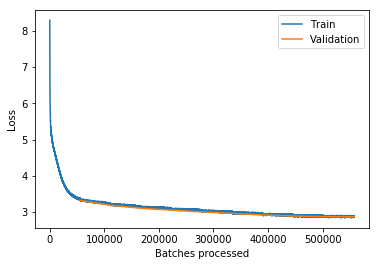

In [73]:
learn.recorder.plot_losses()

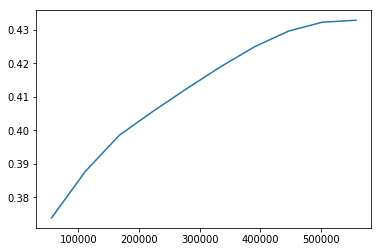

In [74]:
learn.recorder.plot_metrics()

In [90]:
#TEXT = "if i knew back then what i know now," #  i would not agree # seen in polval
TEXT = "Andrew Yan-Tak Ng is a Chinese English computer scientist, executive, investor, "
#TEXT = "i liked this movie because "
N_WORDS = 40
N_SENTENCES = 5

In [91]:
print(("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75, sep="") for _ in range(N_SENTENCES))).replace("▁",""))

Andrew Yan-Tak Ng is a Chinese English computer scientist, executive, investor, en bancs d'amico ou cristal et canmediense is a fiasco of the humanities and social sciences.
Andrew Yan-Tak Ng is a Chinese English computer scientist, executive, investor, inc., english learning and acquisition common law (nrjt) is an established ad subject. (see privacy for those law
Andrew Yan-Tak Ng is a Chinese English computer scientist, executive, investor, acronym dr. dtc, (ikh), a bcse.-then-governmental affairs agency,
Andrew Yan-Tak Ng is a Chinese English computer scientist, executive, investor, zest) is a federally recognized law enforcement agency in the united kingdom whose patents were granted in 2015. the book deals with
Andrew Yan-Tak Ng is a Chinese English computer scientist, executive, investor, ghiu de egnaso gr monica márcio cía llóventa e es sé en


In [92]:
print(("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.25, sep="") for _ in range(N_SENTENCES))).replace("▁",""))

Andrew Yan-Tak Ng is a Chinese English computer scientist, executive, investor, s.a. (spanish: "spatial de sacramento e s.a.") is a secular university in
Andrew Yan-Tak Ng is a Chinese English computer scientist, executive, investor, s.p.a. (see sergeant) is a sovereign state in the united states of america. the 2017
Andrew Yan-Tak Ng is a Chinese English computer scientist, executive, investor, s.a. (dsc) is a framework for enhancing the equitable and integrated framework of the s
Andrew Yan-Tak Ng is a Chinese English computer scientist, executive, investor, s.a. (socialist) (spain) is a sovereign state of the united states of america. the 196
Andrew Yan-Tak Ng is a Chinese English computer scientist, executive, investor, s.a., s.a. (sd) is a sovereign state of the united kingdom. it is a member of the international union of se


In [93]:
pd_train_loss = pd.DataFrame(data=np.hstack([learn.recorder.losses]), 
                             columns=["train_loss"])
pd_train_loss.to_csv(pathTrainValid/f"models/{model.name}/{experiment_name}_train_loss.csv", header="losses")

pd_valid_loss = pd.DataFrame(data=np.column_stack((learn.recorder.val_losses, learn.recorder.metrics)), 
                             columns=["val_loss", "accuracy"])
pd_valid_loss.to_csv(pathTrainValid/f"models/{model.name}/{experiment_name}_valid_loss.csv", header="losses")
pd_train_loss = pd_valid_loss=None
gc.collect()

4902

In [95]:
learn = learn.load(f'{model.name}/{experiment_name}')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (2158673 items)
x: LMTextList
in 1927 the line was further expanded to six tracks (four with electrification) and newtown station was demolished and replaced by the present station which served only the up and down local tracks. the new station was opened on 29 may 1927. the original overhead booking office was retained and its platform access was modified to serve only this new platform. the bookstall for nsw bookstall was constructed in 1937. in the original roof of the platform building was removed and replaced with a lower profile roof. in 1989 the station was refurbished.,joseph m. connolly is an american police detective and politician who represented the 5th middlesex district in the massachusetts house of representatives from 1983 to 1991.,the capsule used two automotive racing seats and aviation brs parachute systems and was designed and modeled with finite element software. the nozzle was carbon fiber exterior with a tou

In [96]:
def create_dataloader_from_ids( ids:Collection[Collection[int]], bs:int, bptt:int, vocab:Vocab, backwards=False, path:str=".", dl_kwargs={} ):
    "Create a dataloader from ids and a `vocab`. `kwargs` are passed to the dataloader creation."
    ids_txtlist = TextList(ids, vocab, path=path, processor=[])
    ids_txtlist = ids_txtlist.split_none()
    ids_txtlist.label_for_lm()
    
    ids_dataset = LanguageModelPreLoader(ids_txtlist, shuffle=False, bs=bs, bptt=bptt, backwards=backwards)
    ids_dl      = DataLoader(ids_dataset, bs, shuffle=False, **dl_kwargs)  
    return DeviceDataLoader(ids_dl, defaults.device, collate_fn=data_collate)
#valid_dl = create_dataloader_from_ids(validIDS_,bs=64,bptt=94,vocab=vocab)   
#learn.validate(valid_dl)

In [97]:
from languagemodelloader import *
def resample(jagged_ids:Collection[Collection[int]], n_samples=None):
    #plot the resampled distribution of sentences according to length
    lengths      = np.fromiter( (len(s) for s in jagged_ids), dtype=np.int16, count=len(jagged_ids) )
    lower, upper, step = np.min(lengths), np.max(lengths), 1
    print(f"number of sentences:{len(lengths)} lower:{lower}, upper:{upper}, step:{step}")
    plt.hist(lengths, upper-lower, density=True, facecolor='g', alpha=0.75, label="sentencelengths" )
    plt.show()

    sampling_bins   = np.arange( lower, upper+1, step)
    buckets         = SampleOnLength(lengths,sampling_bins,min_bucket_size=1000)
    buckets.sampler = random_bucket(nBuckets=len(buckets.buckets))
      
    # make sampling with replacement to change the distribution
    n_samples = np.sum(lengths,dtype=np.int64)  if n_samples is None else n_samples
    print(f"number of samples: {n_samples}")
    resampled  = lengths[ buckets.sample(n=n_samples ) ]
    plt.hist(resampled, upper-lower, density=True, facecolor='g', alpha=0.75, label="resampled distribution of sentence lengths" )
    plt.show()

    sentence_lenght = np.fromiter( (int(np.mean(lengths[b])+.5) for b in buckets.buckets), dtype=np.int, count=len(buckets.buckets))
    bucket_size     = np.fromiter( (len(b) for b in buckets.buckets), dtype=np.int, count=len(buckets.buckets))
    plt.bar(sentence_lenght,bucket_size, label="sentencelength vs bucket size" )
    plt.xlabel("length of sentences in bucket")
    plt.ylabel("number of sentences in bucket")
    plt.title("buckets")
    plt.legend()    
    return buckets


In [103]:
def loss_vs_sentence_length(resampler):
    count,min_lengths,mean_lengths,max_lengths, losses, accuracies = [],[],[],[],[],[]
    for i,bucket in enumerate(resampler.buckets):
        print( f"{int(i/len(resampler.buckets)*100+.5)} %" )
        sentences = validIDS_[bucket]
        lengths   = np.fromiter( (len(s) for s in sentences), dtype=np.int,count=len(bucket) ) 
        b_dl      = create_dataloader_from_ids(sentences,bs=64,bptt=70, vocab=vocab)   
        loss, accuracy = learn.validate(b_dl)
                            
        count.append(len(bucket))
        min_lengths.append(  int(np.min(  lengths ))     ) 
        mean_lengths.append( int(np.mean( lengths )+0.5) )
        max_lengths.append(  int(np.max(  lengths ))     )
        losses.append( loss )
        accuracies.append(accuracy.numpy())
    return pd.DataFrame(data=np.array([count, min_lengths, mean_lengths, max_lengths, losses, accuracies ]).T, 
                        columns=["count", "min_length","mean_length","max_length", "loss","accuracy"])   

number of sentences:452165 lower:15, upper:600, step:1


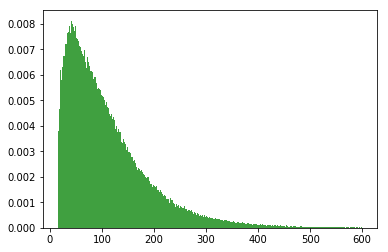

n_buckets:586, lower:15,upper:600,step:1
number of samples: 50000021


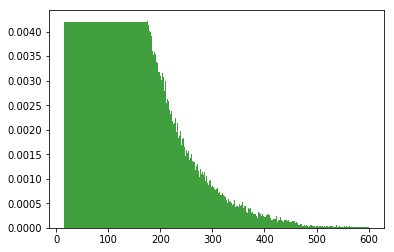

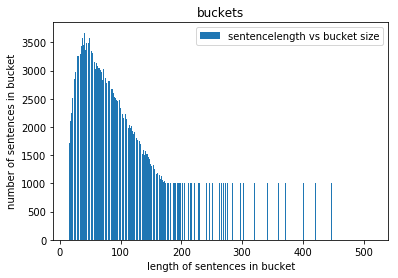

In [99]:
resampler = resample(validIDS_)

In [104]:
loss_vs_sentence = loss_vs_sentence_length(resampler)
loss_vs_sentence

,count,min_length,mean_length,max_length,loss,accuracy
0,1498.0,15.0,15.0,15.0,2.943119,0.453088
1,1720.0,16.0,16.0,16.0,2.968685,0.439732
2,1999.0,17.0,17.0,17.0,2.784698,0.474023
3,2111.0,18.0,18.0,18.0,2.897955,0.449702
4,2250.0,19.0,19.0,19.0,2.896466,0.446964
5,2790.0,20.0,20.0,20.0,2.585726,0.493613
6,2515.0,21.0,21.0,21.0,2.785548,0.461998
7,2618.0,22.0,22.0,22.0,2.875437,0.447081
8,2717.0,23.0,23.0,23.0,2.826774,0.451706
9,2853.0,24.0,24.0,24.0,2.812619,0.454157


In [106]:
loss_vs_sentence.to_csv(pathTrainValid/f"models/{model.name}/{experiment_name}_loss_vs_sentence_length.csv")

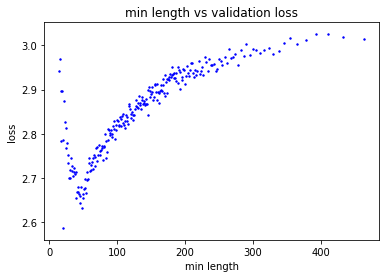

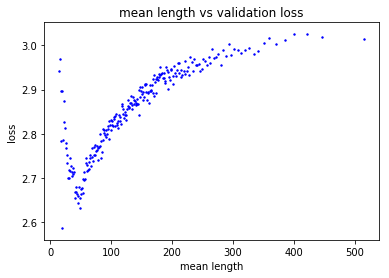

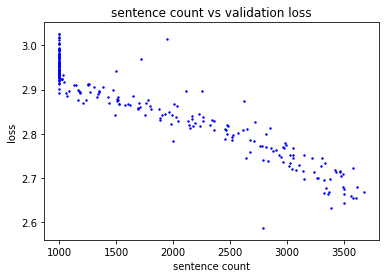

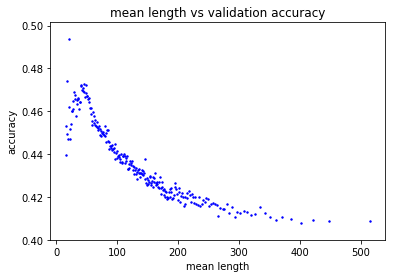

2.585726499557495
     count  min_length  mean_length  max_length      loss  accuracy
0   1498.0        15.0         15.0        15.0  2.943119  0.453088
1   1720.0        16.0         16.0        16.0  2.968685  0.439732
2   1999.0        17.0         17.0        17.0  2.784698  0.474023
3   2111.0        18.0         18.0        18.0  2.897955  0.449702
4   2250.0        19.0         19.0        19.0  2.896466  0.446964
5   2790.0        20.0         20.0        20.0  2.585726  0.493613
6   2515.0        21.0         21.0        21.0  2.785548  0.461998
7   2618.0        22.0         22.0        22.0  2.875437  0.447081
8   2717.0        23.0         23.0        23.0  2.826774  0.451706
9   2853.0        24.0         24.0        24.0  2.812619  0.454157
10  3049.0        25.0         25.0        25.0  2.767271  0.460020
11  2985.0        26.0         26.0        26.0  2.780120  0.460082
12  3055.0        27.0         27.0        27.0  2.752783  0.461266
13  3329.0        28.0        

In [110]:
def plot_losses( title, x_label, y_label, x, y): #, accuracy ):
    plt.scatter(x, y, s=2, c='b')
    #plt.plot(x, loss, c='g', label='loss')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
plot_losses("min length vs validation loss", "min length", "loss", loss_vs_sentence.min_length, loss_vs_sentence.loss)
plt.show()
plot_losses("mean length vs validation loss","mean length", "loss", loss_vs_sentence.mean_length, loss_vs_sentence.loss)
plt.show()
plot_losses("sentence count vs validation loss","sentence count", "loss",  loss_vs_sentence["count"], loss_vs_sentence.loss)
plt.show()
plot_losses("mean length vs validation accuracy","mean length", "accuracy", loss_vs_sentence.mean_length, loss_vs_sentence.accuracy)
plt.show()

print(min(loss_vs_sentence.loss))
print(loss_vs_sentence[0:60])

In [112]:
import hashlib

print(hashlib.algorithms_available)
print(hashlib.algorithms_guaranteed)

{'sm3', 'sha3-256', 'blake2s256', 'sha3_384', 'blake2b512', 'sha512', 'sha1', 'sha3_256', 'sha512-256', 'ripemd160', 'sha3_224', 'shake_128', 'md5-sha1', 'sha3-224', 'md4', 'sha3-384', 'sha3-512', 'mdc2', 'md5', 'whirlpool', 'sha384', 'shake128', 'sha256', 'blake2b', 'shake256', 'sha3_512', 'blake2s', 'sha224', 'shake_256', 'sha512-224'}
{'sha3_256', 'sha256', 'blake2b', 'shake_256', 'sha3_384', 'shake_128', 'md5', 'blake2s', 'sha3_224', 'sha512', 'sha224', 'sha3_512', 'sha1', 'sha384'}


In [118]:
mystring = "Andrew Yan-Tak Ng is a Chinese English computer scientist, executive, investor, "
hash_object = hashlib.md5(mystring.encode()).hexdigest()
print(hash_object)

83c1c3990ddc78052283e4eff624716e


In [119]:
hash_object == hashlib.md5(mystring.encode()).hexdigest()

True